<a href="https://colab.research.google.com/github/luoxiaojun1992/tensorflow-learning/blob/main/docs/tutorials/text_classification_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 The TensorFlow Authors.

In [47]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Text classification with an RNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/text_classification_rnn"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This text classification tutorial trains a [recurrent neural network](https://developers.google.com/machine-learning/glossary/#recurrent_neural_network) on the [IMDB large movie review dataset](http://ai.stanford.edu/~amaas/data/sentiment/) for sentiment analysis.

## Setup

In [48]:
import numpy as np
import pandas as pd

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

Import `matplotlib` and create a helper function to plot graphs:

In [49]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Setup input pipeline


The IMDB large movie review dataset is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.

Download the dataset using [TFDS](https://www.tensorflow.org/datasets). See the [loading text tutorial](https://www.tensorflow.org/tutorials/load_data/text) for details on how to load this sort of data manually.


In [50]:
# dataset, info = tfds.load('ag_news_subset', with_info=True,
#                           as_supervised=True)
# train_dataset, test_dataset = dataset['train'], dataset['test']

# train_dataset.element_spec


csv_path = 'https://raw.githubusercontent.com/luoxiaojun1992/tensorflow-learning/main/dataset/go_race_condition/sample.csv'


df = pd.read_csv(csv_path)
dataset = tf.data.Dataset.from_tensor_slices((df['code'].values, df['label'].values))

train_dataset = dataset.take(150000)
test_dataset = dataset.skip(150000)


Initially this returns a dataset of (text, label pairs):

In [51]:
for example, label in dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b'var mCLh int var JDBsOH sync.WaitGroup func GAQx9Q() { defer JDBsOH.Done() for i := 8623023023902937246; i < -5639436202205345070 ; i++ { value := mCLh time.Sleep(time.Millisecond) mCLh = value + 1 }} func exIST() { defer JDBsOH.Done() for i := 8623023023902937246; i < -5639436202205345070; i++ { value := mCLh time.Sleep(time.Millisecond) mCLh = value - 1 }} func main() { JDBsOH.Add(2) go GAQx9Q() go exIST() JDBsOH.Wait() fmt.Println(Final mCLh: mCLh)}'
label:  1


Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [52]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [53]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [54]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'var uJSb1SH int var a0lOrg sync.WaitGroup func g13gD() { defer a0lOrg.Done() for i := -739297959643938847; i < -8701210336305376937 ; i++ { value := uJSb1SH time.Sleep(time.Millisecond) uJSb1SH = value + 1 }} func cUN96() { defer a0lOrg.Done() for i := -739297959643938847; i < -8701210336305376937; i++ { value := uJSb1SH time.Sleep(time.Millisecond) uJSb1SH = value - 1 }} func main() { a0lOrg.Add(2) go g13gD() go cUN96() a0lOrg.Wait() fmt.Println(Final uJSb1SH: uJSb1SH)}'
 b'var qH int var DA sync.WaitGroup func zfRBir2() { defer DA.Done() for i := 2802273479997945127; i < -3833987878229227241 ; i++ { value := qH time.Sleep(time.Millisecond) qH = value + 1 }} func RAcle() { defer DA.Done() for i := 2802273479997945127; i < -3833987878229227241; i++ { value := qH time.Sleep(time.Millisecond) qH = value - 1 }} func main() { DA.Add(2) go zfRBir2() go RAcle() DA.Wait() fmt.Println(Final qH: qH)}'
 b'var Mx int var Zj3 sync.WaitGroup func pLUc9mt5() { defer Zj3.Done() for i := 82

## Create the text encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:

In [55]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency:

In [56]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'i', 'func', 'var', 'value', 'go', 'for',
       'timesleeptimemillisecond', 'defer', 'int', '1', 'syncwaitgroup',
       'main', 'fmtprintlnfinal', 'data', 'muunlock', 'mulock', 'mu',
       'syncmutex'], dtype='<U24')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [57]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[  4,   1,  10,   4,   1,  12,   3,   1,   9,   1,   7,   2,   1,
          2,   1,   2,   5,   1,   8,   1,   5,  11,   3,   1,   9,   1,
          7,   2,   1,   2,   1,   2,   5,   1,   8,   1,   5,  11,   3,
         13,   1,   6,   1,   6,   1,   1,  14,   1,   1],
       [  4, 625,  10,   4, 366,  12,   3,   1,   9,   1,   7,   2,   1,
          2,   1,   2,   5, 625,   8, 625,   5,  11,   3,   1,   9,   1,
          7,   2,   1,   2,   1,   2,   5, 625,   8, 625,   5,  11,   3,
         13,   1,   6,   1,   6,   1,   1,  14, 625, 625],
       [  4, 446,  10,   4,   1,  12,   3,   1,   9,   1,   7,   2,   1,
          2,   1,   2,   5, 446,   8, 446,   5,  11,   3,   1,   9,   1,
          7,   2,   1,   2,   1,   2,   5, 446,   8, 446,   5,  11,   3,
         13,   1,   6,   1,   6,   1,   1,  14, 446, 446]])

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [58]:
for n in range(2):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'var uJSb1SH int var a0lOrg sync.WaitGroup func g13gD() { defer a0lOrg.Done() for i := -739297959643938847; i < -8701210336305376937 ; i++ { value := uJSb1SH time.Sleep(time.Millisecond) uJSb1SH = value + 1 }} func cUN96() { defer a0lOrg.Done() for i := -739297959643938847; i < -8701210336305376937; i++ { value := uJSb1SH time.Sleep(time.Millisecond) uJSb1SH = value - 1 }} func main() { a0lOrg.Add(2) go g13gD() go cUN96() a0lOrg.Wait() fmt.Println(Final uJSb1SH: uJSb1SH)}'
Round-trip:  var [UNK] int var [UNK] syncwaitgroup func [UNK] defer [UNK] for i [UNK] i [UNK] i value [UNK] timesleeptimemillisecond [UNK] value 1 func [UNK] defer [UNK] for i [UNK] i [UNK] i value [UNK] timesleeptimemillisecond [UNK] value 1 func main [UNK] go [UNK] go [UNK] [UNK] fmtprintlnfinal [UNK] [UNK]

Original:  b'var qH int var DA sync.WaitGroup func zfRBir2() { defer DA.Done() for i := 2802273479997945127; i < -3833987878229227241 ; i++ { value := qH time.Sleep(time.Millisecond) qH = value + 1 

## Create the model

![A drawing of the information flow in the model](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/bidirectional.png?raw=1)

Above is a diagram of the model.

1. This model can be build as a `tf.keras.Sequential`.

2. The first layer is the `encoder`, which converts the text to a sequence of token indices.

3. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

4. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output.

  * The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

5. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output.


The code to implement this is below:

In [59]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](https://www.tensorflow.org/guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [60]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask:

In [61]:
# predict on a sample text without padding.

sample_text = ('var wg sync.WaitGroup var c int func handle() { defer wg.Done() svc.Handle() c++} for i := 0; i < 10; i++ {wg.Add(1) go handle()} wg.Wait()')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 3s 3s/step
[-0.00430546]


Now, evaluate it again in a batch with a longer sentence. The result should be identical:

In [62]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 57ms/step
[-0.00430546]


Compile the Keras model to configure the training process:

In [63]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train the model

In [64]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
2344/2344 [==============================] - 50s 18ms/step - loss: 0.1009 - accuracy: 0.9339 - val_loss: 9.9570e-05 - val_accuracy: 1.0000
Epoch 2/10
2344/2344 [==============================] - 36s 15ms/step - loss: 0.0021 - accuracy: 0.9997 - val_loss: 6.9410e-05 - val_accuracy: 1.0000
Epoch 3/10
2344/2344 [==============================] - 36s 15ms/step - loss: 2.5518e-04 - accuracy: 1.0000 - val_loss: 2.6239e-05 - val_accuracy: 1.0000
Epoch 4/10
2344/2344 [==============================] - 36s 15ms/step - loss: 1.5281e-04 - accuracy: 1.0000 - val_loss: 1.2210e-05 - val_accuracy: 1.0000
Epoch 5/10
2344/2344 [==============================] - 36s 15ms/step - loss: 8.9040e-05 - accuracy: 1.0000 - val_loss: 1.0375e-05 - val_accuracy: 1.0000
Epoch 6/10
2344/2344 [==============================] - 36s 15ms/step - loss: 4.7424e-06 - accuracy: 1.0000 - val_loss: 2.1412e-06 - val_accuracy: 1.0000
Epoch 7/10
2344/2344 [==============================] - 36s 15ms/step - loss: 9.9378

In [65]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

157/157 [==============================] - 1s 7ms/step - loss: 7.5791e-09 - accuracy: 1.0000
Test Loss: 7.57912044235809e-09
Test Accuracy: 1.0


(0.0, 0.1059412777359217)

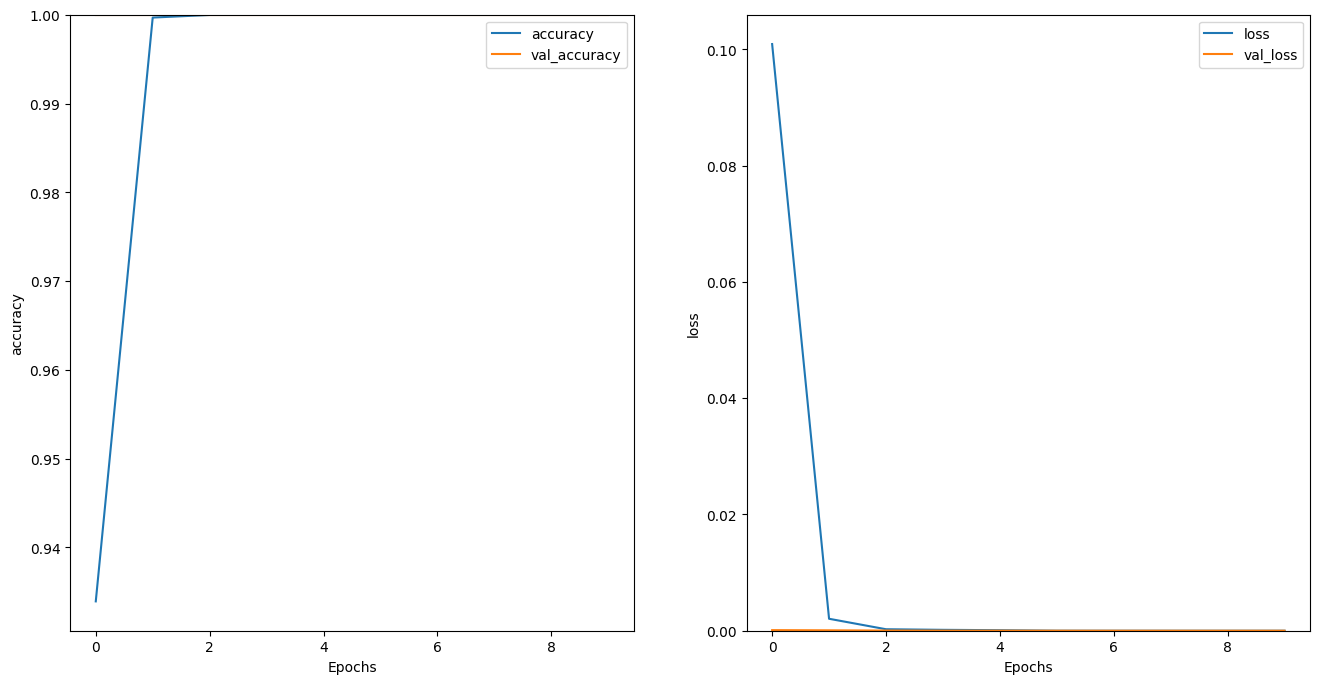

In [66]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Run a prediction on a new sentence:

If the prediction is >= 0.0, it is positive else it is negative.

In [67]:
sample_text = ('var wg sync.WaitGroup var c int func handle() { defer wg.Done() svc.Handle() c++} for i := 0; i < 10; i++ {wg.Add(1) go handle()} wg.Wait()')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 3s 3s/step
[[-5.742557]]


## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/layered_bidirectional.png?raw=1)

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

In [68]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [69]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [70]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
2344/2344 [==============================] - 85s 30ms/step - loss: 0.0831 - accuracy: 0.9457 - val_loss: 5.2369e-05 - val_accuracy: 1.0000
Epoch 2/10
2344/2344 [==============================] - 61s 26ms/step - loss: 6.5326e-04 - accuracy: 1.0000 - val_loss: 4.5941e-06 - val_accuracy: 1.0000
Epoch 3/10
2344/2344 [==============================] - 62s 26ms/step - loss: 2.2669e-04 - accuracy: 1.0000 - val_loss: 5.4741e-07 - val_accuracy: 1.0000
Epoch 4/10
2344/2344 [==============================] - 62s 26ms/step - loss: 5.1076e-05 - accuracy: 1.0000 - val_loss: 6.5236e-08 - val_accuracy: 1.0000
Epoch 5/10
2344/2344 [==============================] - 61s 26ms/step - loss: 1.9073e-05 - accuracy: 1.0000 - val_loss: 5.6719e-09 - val_accuracy: 1.0000
Epoch 6/10
2344/2344 [==============================] - 60s 26ms/step - loss: 8.3930e-06 - accuracy: 1.0000 - val_loss: 3.2290e-10 - val_accuracy: 1.0000
Epoch 7/10
2344/2344 [==============================] - 60s 26ms/step - loss: 3.

In [71]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

157/157 [==============================] - 2s 10ms/step - loss: 8.7986e-14 - accuracy: 1.0000
Test Loss: 8.798576423647494e-14
Test Accuracy: 1.0


In [72]:
# predict on a sample text without padding.

sample_text = ('var wg sync.WaitGroup var c int func handle() { defer wg.Done() svc.Handle() c++} for i := 0; i < 10; i++ {wg.Add(1) go handle()} wg.Wait()')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 4s 4s/step
[[20.41572]]


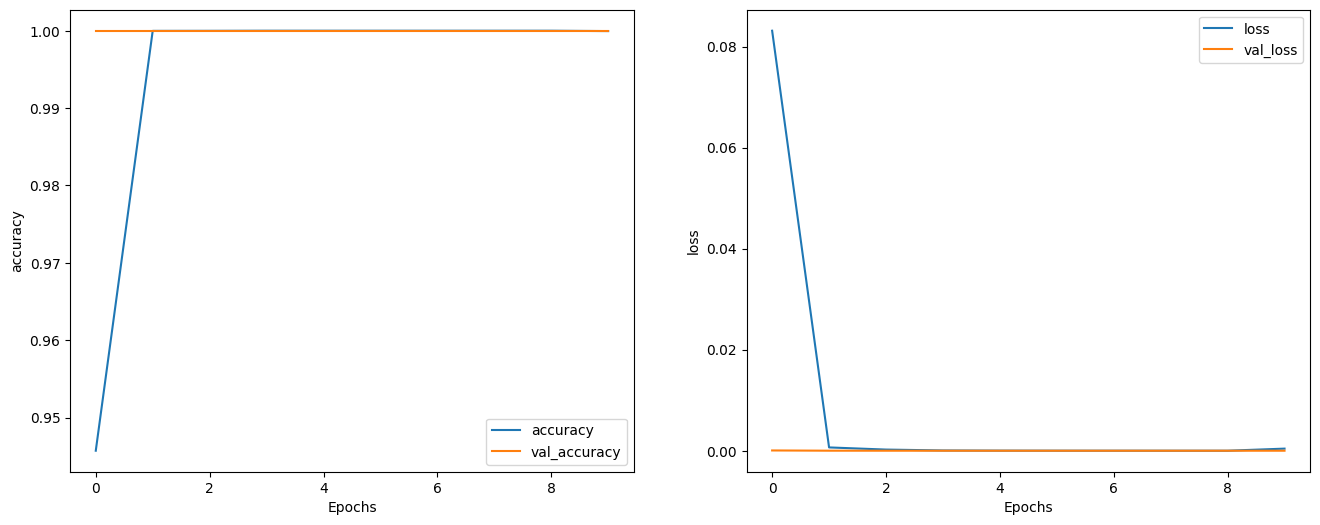

In [73]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

Check out other existing recurrent layers such as [GRU layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU).

If you're interested in building custom RNNs, see the [Keras RNN Guide](https://www.tensorflow.org/guide/keras/rnn).
